In [26]:
%reset

import os
import pprint
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import VotingClassifier

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Vizualization

In [40]:
def learn_curve(str_id, clf, X_train, X_test, y_train, y_test):
    """Get learning curve and confusion matrix
    
    Params
    -------
    str_id : Ideally name of classifier {str}
    clf : classifier {sklearn-obj}
    X_train : {numpy.array}
    X_test : {numpy.array}
    y_train : {numpy.array}
    y_test : {numpy.array}
    
    Creates two png files.
    """
    dest = os.path.join('figures')
    if not os.path.exists(dest):
        os.makedirs(dest)
    
    # get validation curve
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf,
                                   X=X_train,
                                   y=y_train,
                                   train_sizes=np.linspace(0.1, 1.0, 10),
                                   cv=10,
                                   n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')
    plt.tight_layout()
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    lc_name = str_id + 'learning_curve.png'
    plt.savefig('./figures/'+lc_name, dpi=300)
    plt.show()
    
def conf_mat(str_id, clf, X_train, X_test, y_train, y_test):
    """Get learning curve and confusion matrix
    
    Params
    -------
    str_id : Ideally name of classifier {str}
    clf : classifier {sklearn-obj}
    X_train : {numpy.array}
    X_test : {numpy.array}
    y_train : {numpy.array}
    y_test : {numpy.array}
    
    Creates two png files.
    """
    dest = os.path.join('figures')
    if not os.path.exists(dest):
        os.makedirs(dest)
    # confusion matrix
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label', fontsize=15)
    plt.ylabel('true label', fontsize=15)

    #plt.tight_layout()
    cm_name = str_id + 'confusion_matrix.png'
    plt.savefig('./figures/'+cm_name, dpi=300)
    plt.show()

# Models

In [20]:
# These were obtained from previous Gridsearches from the Notebook_gs* scripts
# the results were stored in a subdir named `pkl_objects`

dest = os.path.join('pkl_objects')
gs_clf1 = pickle.load(open(os.path.join(dest, '2gs_logit.pkl'), 'rb'))
gs_clf2 = pickle.load(open(os.path.join(dest, '2gs_svc.pkl'), 'rb'))
gs_clf3 = pickle.load(open(os.path.join(dest, '2gs_nb.pkl'), 'rb'))

clf1 = gs_clf1.best_estimator_
clf2 = gs_clf2.best_estimator_
clf3 = gs_clf3.best_estimator_

print(gs_clf1.best_params_,'\n')
print(gs_clf2.best_params_,'\n')
print(gs_clf3.best_params_,'\n')

{'clf__C': 100.0, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_twitter at 0x7fc917116f28>} 

{'clf__C': 10.0, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_twitter at 0x7fc917116f28>} 

{'clf__alpha': 0.25, 'vect__ngram_range': (1, 2), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_twitter at 0x7fc917116f28>, 'vect__use_idf': False} 



# Visualizing Results

In [28]:
# Out dataset is contained in the following CSV
f_authorship = 'users/authorship.csv'

df = pd.read_csv(f_authorship)
df.drop_duplicates()

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

X = df.loc[:, 'text'].values
y = df.loc[:, 'user_id'].values
le = LabelEncoder()
y = le.fit_transform(y)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=99)

## Majority Vote 

In [36]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

tweet_token = TweetTokenizer()
def tokenizer_twitter(text):
    return tweet_token.tokenize(text)

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        ngram_range=(1,2),
                        stop_words=None,
                        tokenizer=tokenizer_twitter)
tf = TfidfVectorizer(strip_accents=None,
                     lowercase=False,
                     preprocessor=None,
                     ngram_range=(1,2),
                     stop_words=None,
                     tokenizer=tokenizer_twitter,
                     use_idf=False)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(C=100.0, penalty='l1', random_state=1))])
svc_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SVC(C=10.0, gamma=0.1, kernel='rbf', random_state=1))])
nb_tf = Pipeline([('vect', tf),
                    ('clf', MultinomialNB(alpha=0.25))])
rf_tfidf = Pipeline([('vect', tfidf),
                     ('clf', RandomForestClassifier(criterion='entropy', n_estimators=600, random_state=1))])
ens1 = VotingClassifier(estimators=[('lr', lr_tfidf), ('svc', svc_tfidf), ('nb', nb_tf)], voting='hard')
ens2 = VotingClassifier(estimators=[('lr', lr_tfidf), ('rf', rf_tfidf), ('nb', nb_tf)], voting='soft')

In [30]:
# Hard voting
ens1.fit(X_train, y_train)
print('Test Accuracy for hard voting: {:.3f}'.format(ens1.score(X_test, y_test)))

# Soft voting
ens2.fit(X_train, y_train)
print('Test Accuracy for soft voting: {:.3f}'.format(ens2.score(X_test, y_test)))

Test Accuracy for hard voting: 0.856
Test Accuracy for soft voting: 0.858


### Learning curve and confusion matrix forMajority Vote Classifier using Hard voting

In [31]:
%reset_selective ens1 

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


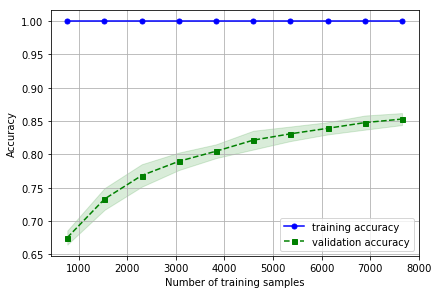

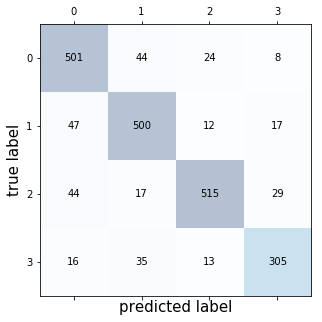

In [32]:
learn_curve('ens1', ens1, X_train, X_test, y_train, y_test)
conf_mat('ens1', ens1, X_train, X_test, y_train, y_test)

### Learning curve and confusion matrix for Majority Vote Classifier using soft voting

In [ ]:
%reset_selective ens2

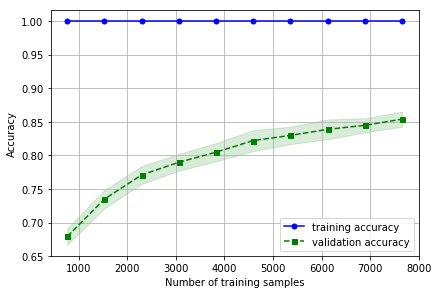

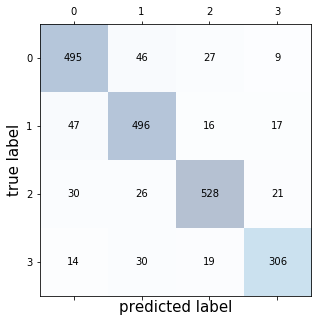

In [33]:
learn_curve('ens2', ens2, X_train, X_test, y_train, y_test)
conf_mat('ens2', ens2, X_train, X_test, y_train, y_test)

### Learning curve and confusion matrix for Logistic Regression model

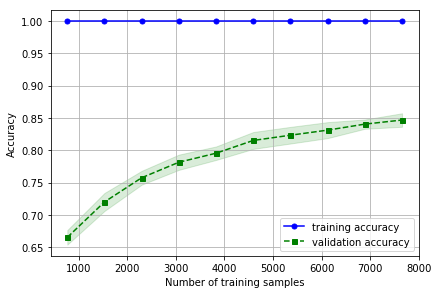

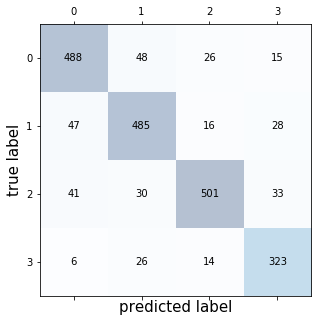

In [41]:
learn_curve('lr', lr_tfidf, X_train, X_test, y_train, y_test)
conf_mat('lr', lr_tfidf, X_train, X_test, y_train, y_test)